# Multivariate  Output  1D CNN Example

Based on:
* [Time Series Forecasting on Stock Prices](https://www.youtube.com/watch?v=j05UUs99eNQ) from [Coding Tech](https://www.youtube.com/channel/UCtxCXg-UvSnTKPOzLH4wJaQ)
* https://machinelearningmastery.com/how-to-develop-convolutional-neural-network-models-for-time-series-forecasting/

**Disclaimer:** _Investing in the stock market involves risk and can lead to monetary loss. This material is purely for educational purposes and should not be taken as professional investment advice. Invest at your own discretion._

Import the libraries

In [1]:
import pandas as pd
import numpy as np

from tensorflow.keras.models import Model
from tensorflow.keras.layers import Input, Conv1D, MaxPooling1D, Flatten, Dense

import matplotlib.pyplot as plt

Load the data

In [2]:
df = pd.read_csv("SP500.csv")

Show the data

In [3]:
df

,Date,Open,High,Low,Close,Volume,Dividends,Stock Splits
0,2000-05-19,96.106028,96.106028,94.484962,94.779701,775500,0.0,0
1,2000-05-22,94.716551,94.716551,92.169162,94.190231,1850600,0.0,0
2,2000-05-23,94.463952,94.463952,92.758675,92.758675,373900,0.0,0
3,2000-05-24,92.800753,94.358660,92.063905,94.148132,400300,0.0,0
4,2000-05-25,94.337613,94.948145,92.884970,93.284973,69600,0.0,0
...,...,...,...,...,...,...,...,...
5359,2021-09-08,452.899994,453.679993,450.869995,453.000000,4076800,0.0,0
5360,2021-09-09,452.690002,454.579987,450.730011,450.980011,3851600,0.0,0
5361,2021-09-10,453.059998,453.510010,447.299988,447.540009,3023500,0.0,0
5362,2021-09-13,450.679993,450.929993,446.089996,448.579987,3007400,0.0,0


Add indices for every day in the period

In [4]:
start_date = df.Date.min()
end_date = df.Date.max()

In [5]:
df_date = pd.date_range(start=start_date, end=end_date).to_frame(name="Date")
df_date.reset_index(drop=True, inplace=True) 

In [6]:
df["Date"] = pd.to_datetime(df["Date"])
df = df.merge(df_date, how='right')

Interpolate missing values

In [7]:
df = df.interpolate(method='linear', limit_direction='both')

Remove not needed columns

In [8]:
df = df[['Date', 'Close']].copy()

In [9]:
df

,Date,Close
0,2000-05-19,94.779701
1,2000-05-20,94.583211
2,2000-05-21,94.386721
3,2000-05-22,94.190231
4,2000-05-23,92.758675
...,...,...
7784,2021-09-10,447.540009
7785,2021-09-11,447.886668
7786,2021-09-12,448.233327
7787,2021-09-13,448.579987


**Simple Moving Average**
* Example periods: 15, 30 or 45 days

In [10]:
def computeSMA(data, period, column='Close'):
    return data[column].rolling(window=period).mean()

In [11]:
df['SMA'] = computeSMA(df, period=15)

**Exponential Moving Averages**
* Example periods: 15, 30 or 45 days

In [12]:
def computeEMA(data, period, column='Close'):
    return data[column].ewm(span=period, adjust=False).mean()

In [13]:
df['EMA'] = computeEMA(df, period=15)

**Relative Strength Index**

In [14]:
def computeRSI(data, period=14, column='Close'):
    delta = data[column].diff(1)
    delta = delta.dropna()
    up = delta.copy()
    down = delta.copy()
    up[up < 0] = 0
    down[down > 0] = 0
    data['up'] = up
    data['down'] = down
    AVG_Gain = computeSMA(data, period, column='up')
    AVG_Loss = abs(computeSMA(data, period, column='down'))
    RS = AVG_Gain / AVG_Loss
    RSI = 100.0 - (100.0 / (1.0 + RS))
    return RSI

In [15]:
df['RSI'] = computeRSI(df, period=14)

**Moving Average Convergence Divergence**

In [16]:
def MACD(data, period1=26, period2=12, signal=9, column='Close'):
    exp1 = computeEMA(data,period1, column=column)
    exp2 = computeEMA(data,period2, column=column)
    data['MACD'] = exp2 - exp1
    data['Signal Line'] = computeSMA(data, signal, column='MACD')

In [17]:
MACD(df)

Remove NaNs

In [18]:
df = df.dropna()

In [19]:
df

,Date,Close,SMA,EMA,up,down,RSI,MACD,Signal Line
14,2000-06-02,99.663971,94.910938,95.600925,1.936874,0.000000,71.245582,0.680463,-0.042866
15,2000-06-03,99.446431,95.222053,96.081613,0.000000,-0.217539,71.115354,0.916439,0.090681
16,2000-06-04,99.228892,95.531765,96.475023,0.000000,-0.217539,70.985601,1.073524,0.250695
17,2000-06-05,99.011353,95.840074,96.792064,0.000000,-0.217539,70.856321,1.167008,0.420929
18,2000-06-06,98.506065,96.127796,97.006314,0.000000,-0.505287,77.029581,1.186644,0.585988
...,...,...,...,...,...,...,...,...,...
7784,2021-09-10,447.540009,453.257671,451.878931,0.000000,-3.440002,30.279938,1.487905,2.619024
7785,2021-09-11,447.886668,452.970782,451.379898,0.346659,0.000000,28.313930,1.046934,2.394046
7786,2021-09-12,448.233327,452.662337,450.986577,0.346659,0.000000,26.233827,0.717167,2.129901
7787,2021-09-13,448.579987,452.332335,450.685753,0.346659,0.000000,24.029401,0.478284,1.844411


Separate a multivariate sequence into samples

In [20]:
def split_sequences(sequences, n_steps):
    X, y = list(), list()
    for i in range(len(sequences)):
        # Find the end of the pattern
        end_ix = i + n_steps
        # Check if we are bound by sequence
        if end_ix > len(sequences) - 1:
            break
        # Gather input and output parts of the pattern
        seq_x, seq_y = sequences[i:end_ix, :], sequences[end_ix, :]
        X.append(seq_x)
        y.append(seq_y)
    
    return np.array(X), np.array(y)

Define input sequence

In [21]:
in_seq1 = df['SMA'].values
in_seq2 = df['EMA'].values
in_seq3 = df['RSI'].values
in_seq4 = df['MACD'].values
in_seq5 = df['Signal Line'].values
out_seq = df['Close'].values

Convert to [rows, columns] structure

In [22]:
in_seq1 = in_seq1.reshape((len(in_seq1), 1))
in_seq2 = in_seq2.reshape((len(in_seq2), 1))
in_seq3 = in_seq3.reshape((len(in_seq3), 1))
in_seq4 = in_seq4.reshape((len(in_seq4), 1))
in_seq5 = in_seq5.reshape((len(in_seq5), 1))
out_seq = out_seq.reshape((len(out_seq), 1))

Horizontally stack columns

In [23]:
dataset = np.hstack((in_seq1, in_seq2, in_seq3, in_seq4, in_seq5, out_seq))

Choose a number of time steps

In [24]:
n_steps = 10

Convert into input/output

In [25]:
X, y = split_sequences(dataset, n_steps)

The dataset knows the number of the features, e.g. 2

In [26]:
n_features = X.shape[2]

Separate output

In [27]:
y1 = y[:,0].reshape((y.shape[0], 1))
y2 = y[:,1].reshape((y.shape[0], 1))
y3 = y[:,2].reshape((y.shape[0], 1))
y4 = y[:,3].reshape((y.shape[0], 1))
y5 = y[:,4].reshape((y.shape[0], 1))
y6 = y[:,5].reshape((y.shape[0], 1))

Set test data

In [28]:
test_size = n_steps
prediction_size = n_features

In [29]:
y1_test = y1[-test_size-prediction_size:-prediction_size]
y2_test = y2[-test_size-prediction_size:-prediction_size]
y3_test = y3[-test_size-prediction_size:-prediction_size]
y4_test = y4[-test_size-prediction_size:-prediction_size]
y5_test = y5[-test_size-prediction_size:-prediction_size]
y6_test = y6[-test_size-prediction_size:-prediction_size]

In [30]:
X_test = X[-test_size-prediction_size:-prediction_size]

In [31]:
y1_expected = y1[-prediction_size:]
y2_expected = y2[-prediction_size:]
y3_expected = y3[-prediction_size:]
y4_expected = y4[-prediction_size:]
y5_expected = y5[-prediction_size:]
y6_expected = y6[-prediction_size:]

In [32]:
y1 = y1[:-test_size-prediction_size]
y2 = y2[:-test_size-prediction_size]
y3 = y3[:-test_size-prediction_size]
y4 = y4[:-test_size-prediction_size]
y5 = y5[:-test_size-prediction_size]
y6 = y6[:-test_size-prediction_size]

In [33]:
X = X[:-test_size-prediction_size]

Define model

In [34]:
visible = Input(shape=(n_steps, n_features))
cnn = Conv1D(filters=64, kernel_size=2, activation='relu')(visible)
cnn = MaxPooling1D(pool_size=2)(cnn)
cnn = Flatten()(cnn)
cnn = Dense(50, activation='relu')(cnn)

Define output 1

In [35]:
output1 = Dense(1)(cnn)

Define output 2

In [36]:
output2 = Dense(1)(cnn)

Define output 3

In [37]:
output3 = Dense(1)(cnn)

Define output 4

In [38]:
output4 = Dense(1)(cnn)

Define output 5

In [39]:
output5 = Dense(1)(cnn)

Define output 6

In [40]:
output6 = Dense(1)(cnn)

Tie together

In [41]:
model = Model(inputs=visible, outputs=[output1, output2, output3, output4, output5, output6])

In [42]:
model.compile(optimizer='adam', loss='mse')

Fit model

In [43]:
model.fit(X, [y1, y2, y3, y4, y5, y6], epochs=300)

Epoch 1/300
243/243 [==============================] - 0s 890us/step - loss: 1760.5887 - dense_1_loss: 277.4461 - dense_2_loss: 323.2195 - dense_3_loss: 460.9644 - dense_4_loss: 28.8217 - dense_5_loss: 59.2095 - dense_6_loss: 610.9277
Epoch 2/300
243/243 [==============================] - 0s 872us/step - loss: 207.4059 - dense_1_loss: 3.3101 - dense_2_loss: 5.1139 - dense_3_loss: 180.5543 - dense_4_loss: 2.2655 - dense_5_loss: 2.6749 - dense_6_loss: 13.4872
Epoch 3/300
243/243 [==============================] - 0s 880us/step - loss: 172.8909 - dense_1_loss: 2.6413 - dense_2_loss: 4.8447 - dense_3_loss: 149.7491 - dense_4_loss: 1.3142 - dense_5_loss: 2.1469 - dense_6_loss: 12.1947
Epoch 4/300
243/243 [==============================] - 0s 948us/step - loss: 158.7495 - dense_1_loss: 2.4156 - dense_2_loss: 4.0891 - dense_3_loss: 138.0170 - dense_4_loss: 1.0750 - dense_5_loss: 1.7031 - dense_6_loss: 11.4498
Epoch 5/300
243/243 [==============================] - 0s 877us/step - loss: 149.971

243/243 [==============================] - 0s 876us/step - loss: 112.7468 - dense_1_loss: 1.2087 - dense_2_loss: 1.1866 - dense_3_loss: 103.0710 - dense_4_loss: 0.3773 - dense_5_loss: 0.3130 - dense_6_loss: 6.5903
Epoch 38/300
243/243 [==============================] - 0s 867us/step - loss: 112.7762 - dense_1_loss: 1.4577 - dense_2_loss: 1.1820 - dense_3_loss: 103.0584 - dense_4_loss: 0.2667 - dense_5_loss: 0.2651 - dense_6_loss: 6.5463
Epoch 39/300
243/243 [==============================] - 0s 901us/step - loss: 111.3110 - dense_1_loss: 1.2125 - dense_2_loss: 1.0781 - dense_3_loss: 101.9357 - dense_4_loss: 0.3483 - dense_5_loss: 0.2329 - dense_6_loss: 6.5034
Epoch 40/300
243/243 [==============================] - 0s 881us/step - loss: 115.3460 - dense_1_loss: 2.0554 - dense_2_loss: 1.8140 - dense_3_loss: 103.4124 - dense_4_loss: 0.3661 - dense_5_loss: 0.3299 - dense_6_loss: 7.3680
Epoch 41/300
243/243 [==============================] - 0s 877us/step - loss: 113.5442 - dense_1_loss: 1.

243/243 [==============================] - 0s 883us/step - loss: 104.8796 - dense_1_loss: 1.0046 - dense_2_loss: 1.0230 - dense_3_loss: 96.7534 - dense_4_loss: 0.1746 - dense_5_loss: 0.1545 - dense_6_loss: 5.7694
Epoch 74/300
243/243 [==============================] - 0s 862us/step - loss: 106.8285 - dense_1_loss: 0.9027 - dense_2_loss: 0.9494 - dense_3_loss: 98.9055 - dense_4_loss: 0.2053 - dense_5_loss: 0.2020 - dense_6_loss: 5.6635
Epoch 75/300
243/243 [==============================] - 0s 854us/step - loss: 103.3724 - dense_1_loss: 0.8320 - dense_2_loss: 0.9424 - dense_3_loss: 95.7506 - dense_4_loss: 0.1790 - dense_5_loss: 0.1232 - dense_6_loss: 5.5452
Epoch 76/300
243/243 [==============================] - 0s 882us/step - loss: 104.2998 - dense_1_loss: 1.1038 - dense_2_loss: 1.2679 - dense_3_loss: 95.7937 - dense_4_loss: 0.2185 - dense_5_loss: 0.1340 - dense_6_loss: 5.7819
Epoch 77/300
243/243 [==============================] - 0s 857us/step - loss: 103.8631 - dense_1_loss: 0.7721

243/243 [==============================] - 0s 865us/step - loss: 101.0152 - dense_1_loss: 0.7193 - dense_2_loss: 0.8644 - dense_3_loss: 93.6710 - dense_4_loss: 0.2267 - dense_5_loss: 0.2206 - dense_6_loss: 5.3132
Epoch 110/300
243/243 [==============================] - 0s 846us/step - loss: 103.5620 - dense_1_loss: 1.4549 - dense_2_loss: 1.4950 - dense_3_loss: 93.9830 - dense_4_loss: 0.1642 - dense_5_loss: 0.1246 - dense_6_loss: 6.3403
Epoch 111/300
243/243 [==============================] - 0s 862us/step - loss: 99.9662 - dense_1_loss: 0.6120 - dense_2_loss: 0.7055 - dense_3_loss: 93.0592 - dense_4_loss: 0.1642 - dense_5_loss: 0.1324 - dense_6_loss: 5.2929
Epoch 112/300
243/243 [==============================] - 0s 862us/step - loss: 99.2237 - dense_1_loss: 0.5989 - dense_2_loss: 0.6806 - dense_3_loss: 92.4697 - dense_4_loss: 0.2017 - dense_5_loss: 0.1497 - dense_6_loss: 5.1231
Epoch 113/300
243/243 [==============================] - 0s 853us/step - loss: 101.6105 - dense_1_loss: 1.19

243/243 [==============================] - 0s 887us/step - loss: 99.9404 - dense_1_loss: 0.8098 - dense_2_loss: 0.9130 - dense_3_loss: 92.5985 - dense_4_loss: 0.1765 - dense_5_loss: 0.1526 - dense_6_loss: 5.2900
Epoch 146/300
243/243 [==============================] - 0s 882us/step - loss: 97.7401 - dense_1_loss: 0.8169 - dense_2_loss: 0.9454 - dense_3_loss: 90.3244 - dense_4_loss: 0.1537 - dense_5_loss: 0.1179 - dense_6_loss: 5.3818
Epoch 147/300
243/243 [==============================] - 0s 843us/step - loss: 96.5605 - dense_1_loss: 0.6749 - dense_2_loss: 0.7895 - dense_3_loss: 89.7693 - dense_4_loss: 0.1597 - dense_5_loss: 0.0909 - dense_6_loss: 5.0763
Epoch 148/300
243/243 [==============================] - 0s 863us/step - loss: 102.9798 - dense_1_loss: 1.3422 - dense_2_loss: 1.4660 - dense_3_loss: 93.4256 - dense_4_loss: 0.2054 - dense_5_loss: 0.1570 - dense_6_loss: 6.3836
Epoch 149/300
243/243 [==============================] - 0s 864us/step - loss: 100.2906 - dense_1_loss: 0.700

243/243 [==============================] - 0s 896us/step - loss: 96.5882 - dense_1_loss: 0.7314 - dense_2_loss: 0.8320 - dense_3_loss: 89.6972 - dense_4_loss: 0.1921 - dense_5_loss: 0.1782 - dense_6_loss: 4.9573
Epoch 182/300
243/243 [==============================] - 0s 832us/step - loss: 96.0091 - dense_1_loss: 0.8629 - dense_2_loss: 0.9251 - dense_3_loss: 88.8497 - dense_4_loss: 0.1378 - dense_5_loss: 0.1082 - dense_6_loss: 5.1255
Epoch 183/300
243/243 [==============================] - 0s 838us/step - loss: 96.6286 - dense_1_loss: 0.6999 - dense_2_loss: 0.7870 - dense_3_loss: 89.7335 - dense_4_loss: 0.1603 - dense_5_loss: 0.1551 - dense_6_loss: 5.0927
Epoch 184/300
243/243 [==============================] - 0s 842us/step - loss: 96.0397 - dense_1_loss: 0.7897 - dense_2_loss: 0.8226 - dense_3_loss: 89.0964 - dense_4_loss: 0.1807 - dense_5_loss: 0.1623 - dense_6_loss: 4.9880
Epoch 185/300
243/243 [==============================] - 0s 855us/step - loss: 98.0055 - dense_1_loss: 0.7502 

243/243 [==============================] - 0s 885us/step - loss: 93.9360 - dense_1_loss: 0.7597 - dense_2_loss: 0.8146 - dense_3_loss: 87.3732 - dense_4_loss: 0.1247 - dense_5_loss: 0.1140 - dense_6_loss: 4.7497
Epoch 218/300
243/243 [==============================] - 0s 850us/step - loss: 93.9763 - dense_1_loss: 0.6501 - dense_2_loss: 0.6972 - dense_3_loss: 87.5610 - dense_4_loss: 0.1334 - dense_5_loss: 0.1185 - dense_6_loss: 4.8161
Epoch 219/300
243/243 [==============================] - 0s 872us/step - loss: 94.0195 - dense_1_loss: 0.6017 - dense_2_loss: 0.6902 - dense_3_loss: 87.6771 - dense_4_loss: 0.1241 - dense_5_loss: 0.1236 - dense_6_loss: 4.8029
Epoch 220/300
243/243 [==============================] - 0s 870us/step - loss: 93.4857 - dense_1_loss: 0.5824 - dense_2_loss: 0.6570 - dense_3_loss: 87.3421 - dense_4_loss: 0.1157 - dense_5_loss: 0.1250 - dense_6_loss: 4.6635
Epoch 221/300
243/243 [==============================] - 0s 889us/step - loss: 94.9911 - dense_1_loss: 0.6522 

243/243 [==============================] - 0s 853us/step - loss: 94.3075 - dense_1_loss: 0.4959 - dense_2_loss: 0.6036 - dense_3_loss: 88.3763 - dense_4_loss: 0.1352 - dense_5_loss: 0.0899 - dense_6_loss: 4.6065
Epoch 254/300
243/243 [==============================] - 0s 833us/step - loss: 94.7444 - dense_1_loss: 0.7127 - dense_2_loss: 0.8037 - dense_3_loss: 88.2377 - dense_4_loss: 0.1356 - dense_5_loss: 0.0875 - dense_6_loss: 4.7672
Epoch 255/300
243/243 [==============================] - 0s 953us/step - loss: 94.6279 - dense_1_loss: 0.5531 - dense_2_loss: 0.6349 - dense_3_loss: 88.6613 - dense_4_loss: 0.1279 - dense_5_loss: 0.0803 - dense_6_loss: 4.5702
Epoch 256/300
243/243 [==============================] - 0s 926us/step - loss: 95.1931 - dense_1_loss: 0.6594 - dense_2_loss: 0.7475 - dense_3_loss: 88.5562 - dense_4_loss: 0.1332 - dense_5_loss: 0.1017 - dense_6_loss: 4.9951
Epoch 257/300
243/243 [==============================] - 0s 887us/step - loss: 93.9933 - dense_1_loss: 0.5291 

243/243 [==============================] - 0s 854us/step - loss: 92.9580 - dense_1_loss: 0.5699 - dense_2_loss: 0.6918 - dense_3_loss: 86.9553 - dense_4_loss: 0.1468 - dense_5_loss: 0.0569 - dense_6_loss: 4.5373
Epoch 290/300
243/243 [==============================] - 0s 851us/step - loss: 94.6925 - dense_1_loss: 1.2536 - dense_2_loss: 1.3087 - dense_3_loss: 86.6875 - dense_4_loss: 0.1433 - dense_5_loss: 0.0454 - dense_6_loss: 5.2540
Epoch 291/300
243/243 [==============================] - 0s 910us/step - loss: 92.3213 - dense_1_loss: 0.6127 - dense_2_loss: 0.7081 - dense_3_loss: 86.1974 - dense_4_loss: 0.1189 - dense_5_loss: 0.0450 - dense_6_loss: 4.6392
Epoch 292/300
243/243 [==============================] - 0s 959us/step - loss: 93.6080 - dense_1_loss: 0.6397 - dense_2_loss: 0.7513 - dense_3_loss: 87.3280 - dense_4_loss: 0.1498 - dense_5_loss: 0.0571 - dense_6_loss: 4.6822
Epoch 293/300
243/243 [==============================] - 0s 1ms/step - loss: 92.5352 - dense_1_loss: 0.4414 - 

Demonstrate training

In [44]:
yhat = model.predict(X)

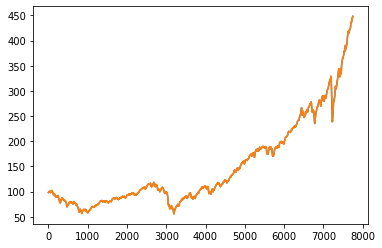

In [45]:
plt.plot(y1)
plt.plot(yhat[0])
plt.show()

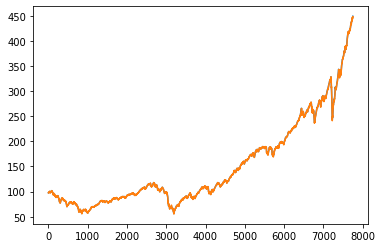

In [46]:
plt.plot(y2)
plt.plot(yhat[1])
plt.show()

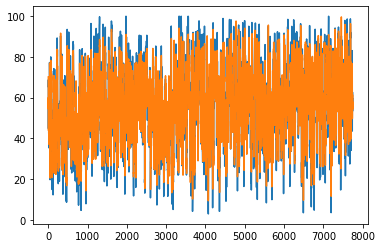

In [47]:
plt.plot(y3)
plt.plot(yhat[2])
plt.show()

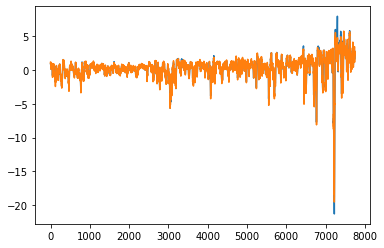

In [48]:
plt.plot(y4)
plt.plot(yhat[3])
plt.show()

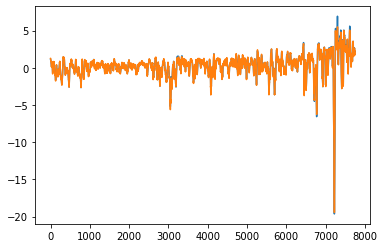

In [49]:
plt.plot(y5)
plt.plot(yhat[4])
plt.show()

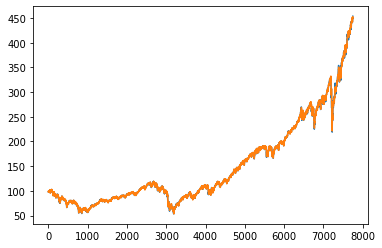

In [50]:
plt.plot(y6)
plt.plot(yhat[5])
plt.show()

Demonstrate prediction

In [51]:
yhat = model.predict(X_test)

In [52]:
print(f"Predicted: {yhat[0][0][0]:.2f}  Expected: {y1_expected[0][0]:.2f}")

Predicted: 447.96  Expected: 453.31


**THIS IS NOT AN INVESTMENT ADVICE!**